In [1]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models import vgg16
from HSI_class import HSI
from datetime import datetime
import zeroPadding
import random
import json
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import pandas as pd
import time

start_time = time.time()

# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# If available, print the GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

seeded_run = True
seed = 55


GPU Available: True
GPU Name: NVIDIA GeForce RTX 4080 SUPER


In [2]:
def set_seed(seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        # For deterministic behavior in CuDNN backend
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set seed at the top

if seeded_run:
    set_seed(seed)
    print("seed has been set")
    print(f"seet used: {seed}")

seed has been set
seet used: 55


In [3]:
dataset_path = r"D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets"

datasets = []


max = 2
i = 0
for filename in os.listdir(dataset_path):
    if i > 9:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        datasets.append(hsi)
    i += 1

Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM01.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM02.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM03.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM04.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM05.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM06.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM07.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM08.mat


In [4]:
def testWithWholeDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    gt= hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {gt.shape}")

    indices0 = np.argwhere(gt == 0)
    indices1 = np.argwhere(gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    return matrix, gt, indices0.shape, indices1.shape

In [5]:
def predict_batch(model, batch_input, device):
    model.eval()
    batch_input = batch_input.to(device)

    with torch.no_grad():
        output = model(batch_input)
        # Apply softmax to get class probabilities
        probabilities = torch.nn.functional.softmax(output, dim=1)

        # Get predicted class (0 or 1)
        predicted_classes = torch.argmax(probabilities, dim=1).cpu().numpy()

        # Get probability of class 1 (positive class) — required for ROC
        positive_class_probs = probabilities[:, 1].cpu().numpy()

    

    return predicted_classes, positive_class_probs


In [6]:
class VGG16_HSI(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16_HSI, self).__init__()

         # Custom Convolutional Layer: Process 9x9x224 input
        self.pre_conv = nn.Sequential(
            nn.Conv2d(in_channels=224, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((1, 1))  # Reduce to (256, 1, 1)
        )

        # Fully Connected Layer to reshape to (64, 56, 56)
        self.fc = nn.Linear(256 * 1 * 1, 64 * 56 * 56)

        # Load VGG-16 Model
        self.encoder = vgg16(pretrained=False)

        # Remove first VGG-16 conv layer
        self.encoder.features = nn.Sequential(*list(self.encoder.features.children())[1:])

        # Modify classifier to output 2 classes
        self.encoder.classifier[6] = nn.Linear(4096, 2)

    def forward(self, x):
        # print(f'before {x.shape}')
        x = self.pre_conv(x)  # Process hyperspectral input
        x = x.view(x.size(0), -1)  # Flatten

        # print(f'after preconv {x.shape}')
        x = self.fc(x)  # Fully connected layer
        # print(f'after fc {x.shape}')
        # Reshape to (batch_size, 64, 56, 56) before passing to VGG
        x = x.view(x.size(0), 64, 56, 56)
        # print(f'after reshape, before vgg second layer {x.shape}')

        x = self.encoder.features(x)  # Pass to VGG-16
        x = self.encoder.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.encoder.classifier(x)  # Final classification layer

        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128

model_path = r"D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\simsiam\simsiam\models\finetune\20250610_195820_model.pth.tar"
model_name = os.path.basename(model_path)

print(f"Creating model {model_name}...")
saved_model = VGG16_HSI(num_classes=2).to(device)

checkpoint = torch.load(model_path, map_location=device)
if 'state_dict' in checkpoint:
    saved_model.load_state_dict(checkpoint['state_dict'])
else:
    saved_model.load_state_dict(checkpoint)  # fallback in case it's a raw state dict

print("Model loaded and moved to device.")

saved_model.eval()
with torch.no_grad():
    dummy_input = torch.randn(1, 224, 9, 9).to(device)
    output = saved_model(dummy_input)
    print("Output shape:", output.shape)

Creating model 20250610_195820_model.pth.tar...


d:\FathanAbi\fathanvenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\FathanAbi\fathanvenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\admin\AppData\Local\Temp\ipykernel_15840\153791228.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped 

Model loaded and moved to device.
Output shape: torch.Size([1, 2])


In [8]:


class PatchDataset(Dataset):
    def __init__(self, matrix, gt, half_patch, expected_shape):
        self.matrix = matrix
        self.gt = gt
        self.half_patch = half_patch
        self.expected_shape = expected_shape
        self.size_x, self.size_y = matrix.shape[0], matrix.shape[1]
        self.valid_coords = [
            (x, y)
            for x in range(half_patch, self.size_x - half_patch)
            for y in range(half_patch, self.size_y - half_patch)
        ]

    def __len__(self):
        return len(self.valid_coords)

    def __getitem__(self, idx):
        x, y = self.valid_coords[idx]
        true_label = self.gt[x - self.half_patch, y - self.half_patch]

        selected_rows = self.matrix[x- self.half_patch:x + 2 * self.half_patch + 1 - self.half_patch, :]
        testing_patch = selected_rows[:, y - self.half_patch:y + 2 * self.half_patch + 1 - self.half_patch]

        # Verify patch size
        if testing_patch.shape != self.expected_shape:
            raise ValueError(f"Patch at ({x},{y}) has wrong shape {testing_patch.shape}")

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.permute(2, 0, 1)  # (C, H, W)

        return patch_tensor, true_label, x, y  # Also return (x, y) for positioning later

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scores = []
groundtruth = []
prediction = []
y_probs = []

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(f"predictions/{timestamp}", exist_ok=True)
for dataset in range(len(datasets)):

    score = []
    patch_size = 9
    half_patch = patch_size // 2

    data_sampler = None
    batch_size = 64

    correct0 = 0
    correct1 = 0
    matrix = []
    gt = []
    expected_patch_shape = []
    dataset_patches = []
    data_loader = []
    patch_tensor = []
    true_label = [] 
    x = []
    y = []
    pred_matrix = []

    matrix, gt, indices_0_shape, indices_1_shape = testWithWholeDataset(dataset)
    print(indices_0_shape[0])
    print(indices_1_shape[0])

    expected_patch_shape = (2 * half_patch + 1, 2 * half_patch + 1, matrix.shape[2])
    dataset_patches = PatchDataset(matrix, gt, half_patch, expected_patch_shape)

    if seeded_run:
        g = torch.Generator()
        g.manual_seed(seed)

        data_loader = DataLoader(
            dataset_patches,
            batch_size=batch_size,
            shuffle=False,  # set to True if needed
            num_workers=0,
            pin_memory=True,
            drop_last=False,
            generator=g
        )
        print("generate data loader using seed")
    else:
        data_loader = DataLoader(dataset_patches, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)


    patch_tensor, true_label, x, y = next(iter(data_loader))

    print(patch_tensor.size())
    print(true_label.size())
    print(f"data loader size: {len(data_loader)}")

    pred_matrix = np.full(gt.shape, -1, dtype=np.int32)
    correct = 0

    for input_batch, label_batch, x_batch, y_batch in tqdm(data_loader, desc="Predicting"):


        preds, confs = predict_batch(saved_model, input_batch, device)

        prediction.append(preds)
        y_probs.append(confs)
        
        label_batch = label_batch.numpy()
        x_batch = x_batch.numpy()
        y_batch = y_batch.numpy()

        for pred, label, x, y in zip(preds, label_batch, x_batch, y_batch):
            groundtruth.append(label)
            pred_matrix[x - half_patch, y - half_patch] = pred
            if pred == label:
                if label == 0:
                    correct0 += 1
                elif label == 1:
                    correct1 += 1
                
    correct = correct0+correct1
    print(f"correct0 = {correct0}")
    print(f"correct1 = {correct1}")
    total = gt.shape[0] * gt.shape[1]
    print(f"Score: {correct}/{total}")

    score = {
        'dataset': dataset,
        'class0_size': indices_0_shape[0],
        'class1_size': indices_1_shape[0],
        'correct_0': correct0,
        'correct_1': correct1,
        'correct_total': correct,
        'total': total
    }
    print(score)
    scores.append(score)
    # Save prediction matrix
    
    np.save(f"predictions/{timestamp}/prediction_matrix_dataset {dataset} MyMethod.npy", pred_matrix)

img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
820876
29336
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13285


Predicting: 100%|██████████| 13285/13285 [02:13<00:00, 99.73it/s] 


correct0 = 781126
correct1 = 21660
Score: 802786/850212
{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 781126, 'correct_1': 21660, 'correct_total': 802786, 'total': 850212}
img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
1236269
12145
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 19507


Predicting: 100%|██████████| 19507/19507 [03:21<00:00, 97.03it/s]


correct0 = 546216
correct1 = 10914
Score: 557130/1248414
{'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 546216, 'correct_1': 10914, 'correct_total': 557130, 'total': 1248414}
img shape: (1386, 690, 224)
img shape after padding (1394, 698, 224)
number of pixel 956340
ground truth shape: (1386, 690)
indices = 0 shape: (916980, 2)
indices = 1 shape: (39360, 2)
916980
39360
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 14943


Predicting: 100%|██████████| 14943/14943 [02:33<00:00, 97.21it/s]


correct0 = 696151
correct1 = 38167
Score: 734318/956340
{'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 696151, 'correct_1': 38167, 'correct_total': 734318, 'total': 956340}
img shape: (1466, 676, 224)
img shape after padding (1474, 684, 224)
number of pixel 991016
ground truth shape: (1466, 676)
indices = 0 shape: (959167, 2)
indices = 1 shape: (31849, 2)
959167
31849
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15485


Predicting: 100%|██████████| 15485/15485 [02:40<00:00, 96.72it/s]


correct0 = 857133
correct1 = 27038
Score: 884171/991016
{'dataset': 3, 'class0_size': 959167, 'class1_size': 31849, 'correct_0': 857133, 'correct_1': 27038, 'correct_total': 884171, 'total': 991016}
img shape: (2085, 682, 224)
img shape after padding (2093, 690, 224)
number of pixel 1421970
ground truth shape: (2085, 682)
indices = 0 shape: (1363408, 2)
indices = 1 shape: (58562, 2)
1363408
58562
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22219


Predicting: 100%|██████████| 22219/22219 [03:52<00:00, 95.68it/s]


correct0 = 1076469
correct1 = 43281
Score: 1119750/1421970
{'dataset': 4, 'class0_size': 1363408, 'class1_size': 58562, 'correct_0': 1076469, 'correct_1': 43281, 'correct_total': 1119750, 'total': 1421970}
img shape: (2088, 691, 224)
img shape after padding (2096, 699, 224)
number of pixel 1442808
ground truth shape: (2088, 691)
indices = 0 shape: (1389552, 2)
indices = 1 shape: (53256, 2)
1389552
53256
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22544


Predicting: 100%|██████████| 22544/22544 [03:55<00:00, 95.75it/s]


correct0 = 1301141
correct1 = 42344
Score: 1343485/1442808
{'dataset': 5, 'class0_size': 1389552, 'class1_size': 53256, 'correct_0': 1301141, 'correct_1': 42344, 'correct_total': 1343485, 'total': 1442808}
img shape: (1965, 492, 224)
img shape after padding (1973, 500, 224)
number of pixel 966780
ground truth shape: (1965, 492)
indices = 0 shape: (873365, 2)
indices = 1 shape: (93415, 2)
873365
93415
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15106


Predicting: 100%|██████████| 15106/15106 [02:37<00:00, 95.79it/s]


correct0 = 403247
correct1 = 93335
Score: 496582/966780
{'dataset': 6, 'class0_size': 873365, 'class1_size': 93415, 'correct_0': 403247, 'correct_1': 93335, 'correct_total': 496582, 'total': 966780}
img shape: (1532, 567, 224)
img shape after padding (1540, 575, 224)
number of pixel 868644
ground truth shape: (1532, 567)
indices = 0 shape: (824964, 2)
indices = 1 shape: (43680, 2)
824964
43680
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13573


Predicting: 100%|██████████| 13573/13573 [02:21<00:00, 95.75it/s]


correct0 = 728667
correct1 = 42496
Score: 771163/868644
{'dataset': 7, 'class0_size': 824964, 'class1_size': 43680, 'correct_0': 728667, 'correct_1': 42496, 'correct_total': 771163, 'total': 868644}
img shape: (1569, 517, 224)
img shape after padding (1577, 525, 224)
number of pixel 811173
ground truth shape: (1569, 517)
indices = 0 shape: (742935, 2)
indices = 1 shape: (68238, 2)
742935
68238
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 12675


Predicting: 100%|██████████| 12675/12675 [02:10<00:00, 96.90it/s]


correct0 = 31865
correct1 = 68238
Score: 100103/811173
{'dataset': 8, 'class0_size': 742935, 'class1_size': 68238, 'correct_0': 31865, 'correct_1': 68238, 'correct_total': 100103, 'total': 811173}
img shape: (1084, 680, 224)
img shape after padding (1092, 688, 224)
number of pixel 737120
ground truth shape: (1084, 680)
indices = 0 shape: (691437, 2)
indices = 1 shape: (45683, 2)
691437
45683
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 11518


Predicting: 100%|██████████| 11518/11518 [01:56<00:00, 98.62it/s] 

correct0 = 684841
correct1 = 10283
Score: 695124/737120
{'dataset': 9, 'class0_size': 691437, 'class1_size': 45683, 'correct_0': 684841, 'correct_1': 10283, 'correct_total': 695124, 'total': 737120}


In [10]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0
class0_total = 0
class1_total = 0

for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    class0_size = score['class0_size']
    class1_size = score['class1_size']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{class0_size}\t', f'{correct1}/{class1_size}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1
    class0_total += class0_size
    class1_total += class1_size



print(f"total: \t\t {all_correct0}/{class0_total/2} \t {all_correct1}/{class1_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")



dataset: 0	 781126/820876	 21660/29336	 802786/850212	
dataset: 1	 546216/1236269	 10914/12145	 557130/1248414	
dataset: 2	 696151/916980	 38167/39360	 734318/956340	
dataset: 3	 857133/959167	 27038/31849	 884171/991016	
dataset: 4	 1076469/1363408	 43281/58562	 1119750/1421970	
dataset: 5	 1301141/1389552	 42344/53256	 1343485/1442808	
dataset: 6	 403247/873365	 93335/93415	 496582/966780	
dataset: 7	 728667/824964	 42496/43680	 771163/868644	
dataset: 8	 31865/742935	 68238/68238	 100103/811173	
dataset: 9	 684841/691437	 10283/45683	 695124/737120	
total: 		 7106856/4909476.5 	 397756/237762.0 	 7504612/10294477
acc: 0.7289940032893366


In [11]:

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'class0_total': class0_total,
    'class1_total': class1_total,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

In [12]:
groundtruths = groundtruth
groundtruth_in = []

for x in groundtruths:
    groundtruth_in.append(x)

predictions = prediction
prediction_in = []

for x in predictions:
    for y in x:
        prediction_in.append(y)


y_prob_in = []

for x in y_probs:
    for y in x:
        y_prob_in.append(y)

print(len(groundtruth_in))
print(len(prediction_in))
print(len(y_prob_in))

10294477
10294477
10294477


In [13]:
y_test = groundtruth_in
y_pred = prediction_in
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

print(f'{correct}/{total}')

7504612/10294477


In [14]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


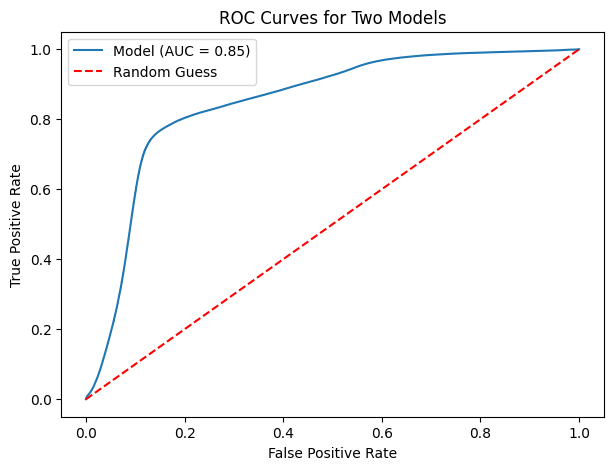

In [15]:


test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob_in})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [16]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction_in                         # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.5585
Recall:    0.7801
F1 Score:  0.5289
OA:        0.7290
AA:        0.7801


In [17]:
performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [18]:
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/MyMethod {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 781126, 'correct_1': 21660, 'correct_total': 802786, 'total': 850212}, {'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 546216, 'correct_1': 10914, 'correct_total': 557130, 'total': 1248414}, {'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 696151, 'correct_1': 38167, 'correct_total': 734318, 'total': 956340}, {'dataset': 3, 'class0_size': 959167, 'class1_size': 31849, 'correct_0': 857133, 'correct_1': 27038, 'correct_total': 884171, 'total': 991016}, {'dataset': 4, 'class0_size': 1363408, 'class1_size': 58562, 'correct_0': 1076469, 'correct_1': 43281, 'correct_total': 1119750, 'total': 1421970}, {'dataset': 5, 'class0_size': 1389552, 'class1_size': 53256, 'correct_0': 1301141, 'correct_1': 42344, 'correct_total': 1343485, 'total': 1442808}, {'dataset': 6, 'class0_size': 873365, 'class1_size': 93415, 'correct_0': 403247, 'correct_1': 93335, 'correct_

In [19]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")

print(timestamp)
print(f"seet used: {seed}")

Run time: 1698.3460 seconds
20250612_121834
seet used: 55
